In [2]:
from paretoKnapsackRestaurants import *

import shutil
import matplotlib as mpl

# Enable LaTeX rendering if available (fallback to Matplotlib text otherwise)
if shutil.which("latex"):
    mpl.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amssymb}",
    })
else:
    mpl.rcParams.update({"text.usetex": False})

In [2]:
#function to sample numItems from the dataset
def sample_dataset(simMatrix, item_ids, item_costs, numItems):
    '''
    Samples a subset of items from the dataset.
    Args:
        simMatrix (np.ndarray): Similarity matrix of shape (N, N).
        item_ids (list): List of item IDs of length N.
        item_costs (list): List of item costs of length N.
        numItems (int): Number of items to sample.
    Returns:
        sampled_simMatrix (np.ndarray): Sampled similarity matrix of shape (numItems, numItems).
        sampled_item_ids (list): List of sampled item IDs of length numItems.
        sampled_item_costs (list): List of sampled item costs of length numItems.
    '''
    sampled_indices = np.random.choice(len(item_ids), size=numItems, replace=False)
    sampled_simMatrix = simMatrix[np.ix_(sampled_indices, sampled_indices)]
    sampled_item_ids = [item_ids[i] for i in sampled_indices]
    sampled_item_costs = [item_costs[i] for i in sampled_indices]

    return sampled_simMatrix, sampled_item_ids, sampled_item_costs

### Yelp - Average plotting across different random samples

In [ ]:
def findApproximateParetoSolutions(simMatrix, item_ids, item_costs, sample_size, numSamples, maxBudget, dataset_name=None):
    '''
    Run algorithms over multiple random samples of the dataset, aggregate results, and plot mean +/- std.
    Args:
        simMatrix (np.ndarray): Similarity matrix of shape (N, N).
        item_ids (list): List of item IDs of length N.      
        item_costs (list): List of item costs of length N.
        sample_size (int): Number of items to sample from the dataset.
        numSamples (int): Number of random samples to run.
        maxBudget (float): Maximum budget for the knapsack problem.
        dataset_name (str | None): Optional dataset name for output file naming.
    '''
    # Cost grid (same for all samples)
    num_steps, min_cost = 25, 1
    cost_arr = np.linspace(min_cost, maxBudget, num_steps)

    algo_names = ["FC-Greedy", "ParetoGreedy", "C-Greedy", "TopK"]

    # containers across samples
    all_objectives = {alg: [] for alg in algo_names}
    all_runtimes = {alg: [] for alg in algo_names}
    pareto_costs_all = []
    pareto_points_counts = []

    # frontier size counts per sample
    pareto_size_counts = []
    fcgreedy_size_counts = []
    cgreedy_size_counts = []
    topk_size_counts = []

    print(f"Starting processing {numSamples} samples with sample size {sample_size} and max budget {maxBudget}")

    # iterate samples
    for sample_index in range(numSamples):
        print(f"Processing sample {sample_index + 1}/{numSamples}")
        
        # per-sample containers (will be appended to across budgets)
        sample_objectives = {alg: [] for alg in algo_names}
        sample_costs = {alg: [] for alg in algo_names}
        sample_runtimes = {alg: [] for alg in algo_names}

        # sample the dataset
        sampled_simMatrix, sampled_item_ids, sampled_item_costs = sample_dataset(simMatrix, item_ids, item_costs, sample_size)

        for budgetVal in cost_arr:
            # Initialize Pareto restaurants object
            paretoRest = paretoKnapsackRestaurants(n_items=sampled_item_ids,
                                                   costs=sampled_item_costs,
                                                   simMatrix=sampled_simMatrix,
                                                   budget=budgetVal)

            # C-Greedy (plain Greedy)
            # if "C-Greedy" in algo_names:
            #     plain_items, curr_objective, curr_cost, runTime = paretoRest.plainGreedy()
            #     sample_objectives['C-Greedy'].append(curr_objective)
            #     sample_costs['C-Greedy'].append(curr_cost)
            #     sample_runtimes['C-Greedy'].append(runTime)
            # else:
            #     plain_items = []

            # C-Greedy (one-guess Greedy Plus)
            if "C-Greedy" in algo_names:
                _, curr_objective, curr_cost, runTime = paretoRest.oneGuessGreedyPlus()
                sample_objectives['C-Greedy'].append(curr_objective)
                sample_costs['C-Greedy'].append(curr_cost)
                sample_runtimes['C-Greedy'].append(runTime)

            # Top-k (add items by score until budget is exhausted)
            if "TopK" in algo_names:
                _, curr_objective, curr_cost, runTime = paretoRest.top_k()
                sample_objectives['TopK'].append(curr_objective)
                sample_costs['TopK'].append(curr_cost)
                sample_runtimes['TopK'].append(runTime)

        if "C-Greedy" in algo_names:
            cgreedy_size_counts.append(len(sample_objectives['C-Greedy']))
        if "TopK" in algo_names:
            topk_size_counts.append(len(sample_objectives['TopK']))

        # Pareto Greedy + FC-Greedy (computed once per sample at full budget)
        if any(alg in algo_names for alg in ["ParetoGreedy", "FC-Greedy"]):
            print(f"  Running Pareto/grid algorithms for sample {sample_index + 1}")
            paretoRest_full = paretoKnapsackRestaurants(n_items=sampled_item_ids,
                                                        costs=sampled_item_costs,
                                                        simMatrix=sampled_simMatrix,
                                                        budget=maxBudget)
        else:
            paretoRest_full = None

        if "ParetoGreedy" in algo_names:
            pg1_costs, pg1_objectives, _, pg1_time = paretoRest_full.prefixParetoGreedy_1Guess()
        else:
            pg1_costs, pg1_objectives, pg1_time = [], [], 0.0

        if "FC-Greedy" in algo_names:
            fc_costs, fc_objectives, fc_time = paretoRest_full.FC_Greedy()
        else:
            fc_costs, fc_objectives, fc_time = [], [], 0

        # Ensure objectives align with the cost_arr length if possible.
        # We'll resample/pad to cost_arr length: simplest is to interpolate by cost.
        def align_to_cost_arr(costs, objs):
            if len(costs) == 0:
                return np.zeros_like(cost_arr, dtype=float)
            costs = np.array(costs, dtype=float)
            objs = np.array(objs, dtype=float)
            order = np.argsort(costs)
            costs = costs[order]
            objs = objs[order]
            return np.interp(cost_arr, costs, objs, left=objs[0], right=objs[-1])

        if "ParetoGreedy" in algo_names:
            sample_objectives['ParetoGreedy'] = list(align_to_cost_arr(pg1_costs, pg1_objectives))
            sample_runtimes['ParetoGreedy'].append(pg1_time)
            pareto_costs_all.extend(pg1_costs)
            pareto_points_counts.append(len(pg1_costs))
            pareto_size_counts.append(len(pg1_objectives))

        if "FC-Greedy" in algo_names:
            sample_objectives['FC-Greedy'] = list(align_to_cost_arr(fc_costs, fc_objectives))
            sample_runtimes['FC-Greedy'].append(fc_time)
            fcgreedy_size_counts.append(len(fc_objectives))

        # convert per-sample lists to numpy arrays and store in all_objectives
        for alg in algo_names:
            arr = np.array(sample_objectives[alg], dtype=float)
            if arr.size == 0:
                arr = np.zeros_like(cost_arr, dtype=float)
            all_objectives[alg].append(arr)
            # store total runtime per sample (sum over budgets or single value for pareto)
            runtimes = sample_runtimes.get(alg, [])
            total_runtime = float(np.nansum(np.array(runtimes, dtype=float))) if len(runtimes) > 0 else 0.0
            all_runtimes[alg].append(total_runtime)

        print(f"Completed sample {sample_index + 1}")

    print("All samples processed, computing statistics and plotting")

    # compute mean and std across samples for each algorithm
    mean_objectives = {}
    std_objectives = {}
    for alg in algo_names:
        stacked = np.vstack(all_objectives[alg])  # shape (numSamples, len(cost_arr))
        mean_objectives[alg] = np.mean(stacked, axis=0)
        std_objectives[alg] = np.std(stacked, axis=0)*0.5  # reduce std for better visualization

    mean_pareto_points = float(np.mean(pareto_points_counts)) if len(pareto_points_counts) > 0 else 0.0

    mean_pareto_size = float(np.mean(pareto_size_counts)) if len(pareto_size_counts) > 0 else 0.0
    mean_fcgreedy_size = float(np.mean(fcgreedy_size_counts)) if len(fcgreedy_size_counts) > 0 else 0.0
    mean_cgreedy_size = float(np.mean(cgreedy_size_counts)) if len(cgreedy_size_counts) > 0 else 0.0
    mean_topk_size = float(np.mean(topk_size_counts)) if len(topk_size_counts) > 0 else 0.0

    def sample_scatter_costs(mean_points, rng):
        if cost_arr.size == 0 or mean_points <= 0:
            return np.array([], dtype=float)
        target_count = int(np.clip(np.round(mean_points), 1, cost_arr.size))
        base_idx = np.linspace(0, cost_arr.size - 1, target_count)
        base_idx = np.round(base_idx).astype(int)
        jitter = rng.integers(-1, 2, size=target_count)
        idx = np.clip(base_idx + jitter, 0, cost_arr.size - 1)
        idx = np.unique(idx)
        if idx.size < target_count:
            remaining = np.setdiff1d(np.arange(cost_arr.size), idx)
            if remaining.size > 0:
                extra = rng.choice(remaining, size=min(target_count - idx.size, remaining.size), replace=False)
                idx = np.sort(np.concatenate([idx, extra]))
        return cost_arr[idx]

    # Plot mean objective with shaded std band (consistent with teams plotting)
    tab10_colors = plt.get_cmap("tab10").colors
    color_map = {
        "TopK": tab10_colors[4],
        "C-Greedy": tab10_colors[1],
        "ParetoGreedy": tab10_colors[3],
        "FC-Greedy": tab10_colors[0],
    }
    marker_map = {
        "TopK": "o",
        "C-Greedy": "^",
        "ParetoGreedy": "X",
        "FC-Greedy": "P",
    }
    linestyle_map = {
        "TopK": (0, (1, 1)),
        "C-Greedy": (0, (2, 2)),
        "ParetoGreedy": (0, (4, 2)),
        "FC-Greedy": (0, (2, 1, 1, 1)),
    }

    fig, ax = plt.subplots(figsize=(9, 5.5))
    rng = np.random.default_rng()
    for i, alg in enumerate(algo_names):
        mean = mean_objectives[alg]
        std = std_objectives[alg]
        is_pareto = alg in {"ParetoGreedy"}
        marker_size = 7
        if is_pareto:
            marker_size = marker_size * 1.1
        line_style = linestyle_map.get(alg, (0, (1, 1)))

        color = color_map.get(alg, tab10_colors[i % len(tab10_colors)])
        marker = marker_map.get(alg, 'o')
        zorder = 3
        if alg == "ParetoGreedy":
            zorder = 4

        if is_pareto:
            ax.plot(cost_arr, mean,
                    label="_nolegend_",
                    color=color,
                    linestyle=line_style,
                    linewidth=1.8,
                    zorder=zorder)
            scatter_costs = sample_scatter_costs(mean_pareto_points, rng)
            if scatter_costs.size > 0:
                scatter_mean_vals = np.interp(scatter_costs, cost_arr, mean)
                ax.scatter(scatter_costs, scatter_mean_vals,
                           label="_nolegend_",
                           color=color,
                           marker=marker,
                           s=(marker_size*1.1)**2,
                           linewidths=0,
                           zorder=zorder + 1)
        else:
            ax.plot(cost_arr, mean,
                    color=color,
                    linestyle=line_style,
                    marker=marker,
                    markersize=marker_size,
                    markeredgewidth=0,
                    markeredgecolor='none',
                    linewidth=1.8,
                    zorder=zorder)
        ax.fill_between(cost_arr,
                        np.clip(mean - std, 0, None),
                        mean + std,
                        color=color,
                        alpha=0.18,
                        zorder=2)

    ax.set_xlabel(r'Cost, $c_\ell$', fontsize=28)
    ax.set_ylabel(r'Objective, $f$', fontsize=28)
    ax.set_title("")
    ax.grid(alpha=0.3)
    ax.tick_params(axis='both', labelsize=24)

    # Save figure
    from pathlib import Path
    base_dir = Path.cwd().resolve().parents[1]
    plots_dir = base_dir / "plots" / "knapsack"
    plots_dir.mkdir(parents=True, exist_ok=True)
    safe_name = (dataset_name or "dataset").replace(" ", "_")
    out_path = plots_dir / f"{safe_name}_knapsack.pdf"
    fig.savefig(out_path, bbox_inches="tight")

    plt.show()

    # Runtime summary (latex row)
    dataset_label = dataset_name or "dataset"
    dataset_macro_map = {
        "Yelp-PHX": r"\yelpphoenix",
        "Yelp-LV": r"\yelpvegas",
    }
    dataset_macro = dataset_macro_map.get(dataset_label, rf"\\dataset{{{dataset_label}}}")
    mean_cgreedy_rt = float(np.mean(all_runtimes['C-Greedy'])) if len(all_runtimes['C-Greedy']) > 0 else 0.0
    mean_fcgreedy_rt = float(np.mean(all_runtimes['FC-Greedy'])) if len(all_runtimes['FC-Greedy']) > 0 else 0.0
    mean_pareto_rt = float(np.mean(all_runtimes['ParetoGreedy'])) if len(all_runtimes['ParetoGreedy']) > 0 else 0.0
    mean_topk_rt = float(np.mean(all_runtimes['TopK'])) if len(all_runtimes['TopK']) > 0 else 0.0
    runtime_row = (
        f"{dataset_macro} "
        f"& {mean_cgreedy_rt:.3f} "
        f"& -- "
        f"& {mean_fcgreedy_rt:.3f} "
        f"& {mean_pareto_rt:.3f} "
        f"& {mean_topk_rt:.3f} \\\\"
    )
    logging.info(runtime_row)

    # Mean frontier sizes summary (latex row)
    frontier_row = (
        f"{dataset_macro} "
        f"& {mean_cgreedy_size:.3f} "
        f"& -- "
        f"& {mean_fcgreedy_size:.3f} "
        f"& {mean_pareto_size:.3f} "
        f"& {mean_topk_size:.3f} \\\\"
    )
    logging.info(frontier_row)

    summary_dir = plots_dir / "summary"
    summary_dir.mkdir(parents=True, exist_ok=True)
    runtimes_path = summary_dir / "runtimes.txt"
    frontier_path = summary_dir / "frontier-size.txt"
    with open(runtimes_path, "a", encoding="utf-8") as runtime_file:
        runtime_file.write(runtime_row + "\n")
    with open(frontier_path, "a", encoding="utf-8") as frontier_file:
        frontier_file.write(frontier_row + "\n")

### Yelp Phoenix Experiments

In [3]:
#Import Yelp dataset
data_path = '../../datasets/pickled_data/yelp/yelp_phoenix_'
    
#Import pickled data
with open(data_path + 'ids.pkl', "rb") as fp:
    phoenix_ids = pickle.load(fp)

with open(data_path + 'sim.pkl', "rb") as fp:
    phoenix_simMatrix = pickle.load(fp)

with open(data_path + 'costs.pkl', "rb") as fp:
    phoenix_costs = pickle.load(fp)


2026-02-06 18:04:09,540 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=1.0
2026-02-06 18:04:09,550 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=3.0416666666666665
2026-02-06 18:04:09,590 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=5.083333333333333
2026-02-06 18:04:09,681 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=7.125


Starting processing 2 samples with sample size 100 and max budget 50
Processing sample 1/2


2026-02-06 18:04:09,863 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=9.166666666666666
2026-02-06 18:04:10,248 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=11.208333333333332
2026-02-06 18:04:10,855 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=13.25
2026-02-06 18:04:11,885 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=15.291666666666666
2026-02-06 18:04:13,055 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=17.333333333333332
2026-02-06 18:04:14,450 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=19.375
2026-02-06 18:04:16,127 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=21.416666666666664
2026-02-06 18:04:18,101 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=23.458333333333332
20

  Running Pareto/grid algorithms for sample 1


2026-02-06 18:05:36,507 |INFO: Cost epsilon grid: eps=0.100, min_cost=0.119, max_budget=50.000, points=65
2026-02-06 18:06:33,914 |INFO: CoverageLinear epsilon grid: eps=0.100, min_obj=2.583, max_obj=100.000, points=40
2026-02-06 18:06:35,251 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=1.0
2026-02-06 18:06:35,266 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=3.0416666666666665
2026-02-06 18:06:35,386 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=5.083333333333333


Completed sample 1
Processing sample 2/2


2026-02-06 18:06:35,665 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=7.125
2026-02-06 18:06:36,114 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=9.166666666666666
2026-02-06 18:06:36,840 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=11.208333333333332
2026-02-06 18:06:37,985 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=13.25
2026-02-06 18:06:39,511 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=15.291666666666666
2026-02-06 18:06:41,417 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=17.333333333333332
2026-02-06 18:06:43,724 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=19.375
2026-02-06 18:06:46,829 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=21.416666666666664
2026-02-06 18:0

  Running Pareto/grid algorithms for sample 2


2026-02-06 18:08:46,583 |INFO: Cost epsilon grid: eps=0.100, min_cost=0.119, max_budget=50.000, points=65
2026-02-06 18:10:19,440 |INFO: CoverageLinear epsilon grid: eps=0.100, min_obj=3.047, max_obj=100.000, points=38


Completed sample 2
All samples processed, computing statistics and plotting


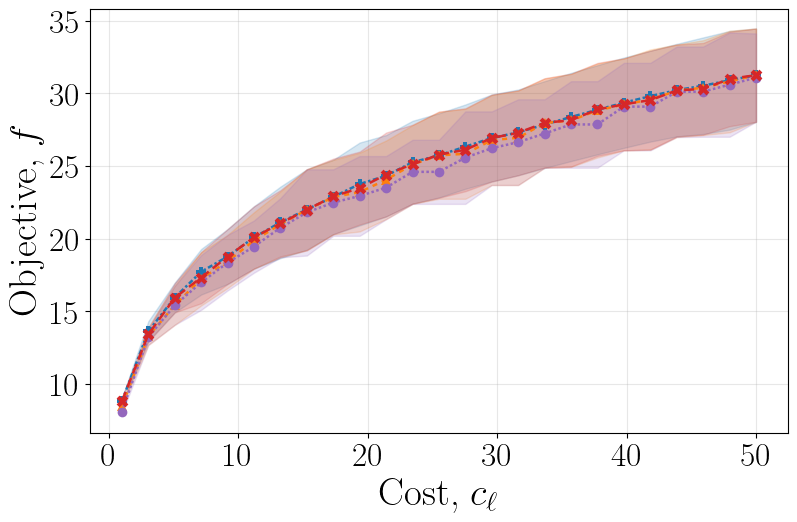

2026-02-06 18:10:23,102 |INFO: \yelpphoenix & 99.994 & -- & 76.680 & 9.107 & 0.028 \\
2026-02-06 18:10:23,105 |INFO: \yelpphoenix & 25.000 & -- & 38.500 & 73.500 & 25.000 \\


In [5]:
# Call findApproximateParetoSolutions (adjust parameters as needed)
sample_size = 100
numSamples = 2  # e.g., number of random samples
maxBudget = 50

findApproximateParetoSolutions(phoenix_simMatrix, phoenix_ids, phoenix_costs, sample_size, numSamples, maxBudget, dataset_name="Yelp-PHX")

### Yelp Vegas Experiments

In [4]:
#Import Vegas dataset
data_path = '../../datasets/pickled_data/yelp/yelp_vegas_' 

#Import pickled data
with open(data_path + 'ids.pkl', "rb") as fp:
    vegas_ids = pickle.load(fp)

with open(data_path + 'sim.pkl', "rb") as fp:
    vegas_simMatrix = pickle.load(fp)

with open(data_path + 'costs.pkl', "rb") as fp:
    vegas_costs = pickle.load(fp)

2026-02-06 18:10:23,160 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=1.0
2026-02-06 18:10:23,162 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=3.0416666666666665
2026-02-06 18:10:23,184 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=5.083333333333333
2026-02-06 18:10:23,244 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=7.125


Starting processing 2 samples with sample size 100 and max budget 50
Processing sample 1/2


2026-02-06 18:10:23,491 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=9.166666666666666
2026-02-06 18:10:23,804 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=11.208333333333332
2026-02-06 18:10:24,363 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=13.25
2026-02-06 18:10:25,311 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=15.291666666666666
2026-02-06 18:10:26,383 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=17.333333333333332
2026-02-06 18:10:28,041 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=19.375
2026-02-06 18:10:30,091 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=21.416666666666664
2026-02-06 18:10:32,468 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=23.458333333333332
20

  Running Pareto/grid algorithms for sample 1


2026-02-06 18:11:58,400 |INFO: Cost epsilon grid: eps=0.100, min_cost=0.638, max_budget=50.000, points=47
2026-02-06 18:12:59,708 |INFO: CoverageLinear epsilon grid: eps=0.100, min_obj=2.924, max_obj=100.000, points=39
2026-02-06 18:13:00,866 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=1.0
2026-02-06 18:13:00,868 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=3.0416666666666665
2026-02-06 18:13:00,880 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=5.083333333333333
2026-02-06 18:13:00,912 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=7.125
2026-02-06 18:13:01,008 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=9.166666666666666


Completed sample 1
Processing sample 2/2


2026-02-06 18:13:01,226 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=11.208333333333332
2026-02-06 18:13:01,588 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=13.25
2026-02-06 18:13:02,274 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=15.291666666666666
2026-02-06 18:13:03,327 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=17.333333333333332
2026-02-06 18:13:04,768 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=19.375
2026-02-06 18:13:06,816 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=21.416666666666664
2026-02-06 18:13:09,142 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=23.458333333333332
2026-02-06 18:13:12,127 |INFO: Initialized Pareto Restaurant - Knapsack Cost Instance, Num Items:100, Budget=25.5
2026-02-06 18:1

  Running Pareto/grid algorithms for sample 2


2026-02-06 18:14:30,741 |INFO: Cost epsilon grid: eps=0.100, min_cost=0.531, max_budget=50.000, points=49
2026-02-06 18:15:29,604 |INFO: CoverageLinear epsilon grid: eps=0.100, min_obj=2.718, max_obj=100.000, points=39


Completed sample 2
All samples processed, computing statistics and plotting


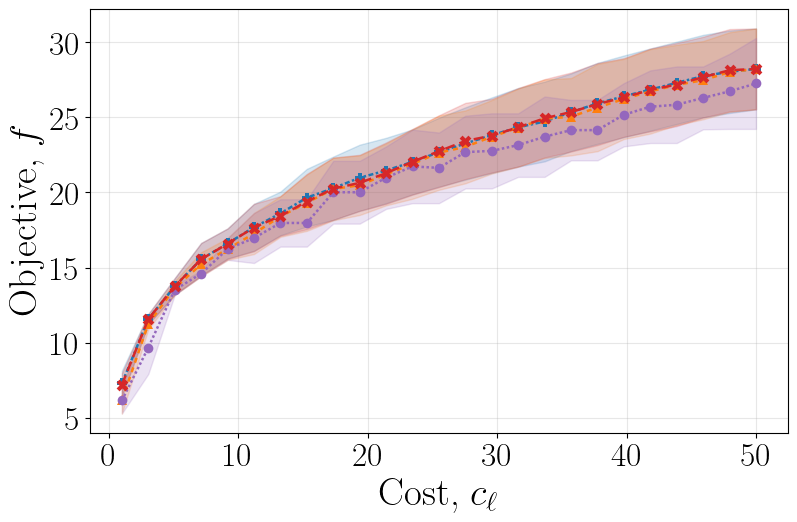

2026-02-06 18:15:31,182 |INFO: \yelpvegas & 84.803 & -- & 61.316 & 7.710 & 0.024 \\
2026-02-06 18:15:31,183 |INFO: \yelpvegas & 25.000 & -- & 30.000 & 62.000 & 25.000 \\


In [7]:
# Call findApproximateParetoSolutions (adjust parameters as needed)
sample_size = 100
numSamples = 2  # e.g., number of random samples
maxBudget = 50

findApproximateParetoSolutions(vegas_simMatrix, vegas_ids, vegas_costs, sample_size, numSamples, maxBudget, dataset_name="Yelp-LV")